# Predict Next Lottery number
- each picker models


## Omajinai
### imports

In [1]:
import joblib
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.rc('font', family='Cascadia Code PL')
plt.rcParams['figure.figsize'] = (16, 6)
import plotly.express as px

In [72]:
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [3]:
print('sklearn:', sklearn.__version__)
print('keras:', keras.__version__)
print('tensorflow:', tf.__version__)
print('pandas:', pd.__version__)

sklearn: 1.0.2
keras: 2.8.0
tensorflow: 2.8.0
pandas: 1.4.1


### configs

In [4]:
data_url = 'https://loto7.thekyo.jp/data/loto7.csv'
data_path = '../data/jpn/loto7/loto7.csv'
max_n = 37
picks = 7
first_pick_col = 1

## Data

In [5]:
!wget https://loto7.thekyo.jp/data/loto7.csv -O $data_path

--2022-03-21 11:30:47--  https://loto7.thekyo.jp/data/loto7.csv
Resolving loto7.thekyo.jp (loto7.thekyo.jp)... 133.242.141.109
Connecting to loto7.thekyo.jp (loto7.thekyo.jp)|133.242.141.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51609 (50K) [text/csv]
Saving to: ‘../data/jpn/loto7/loto7.csv’

../data/jpn/loto7/l 100%[===================>]  50.40K  --.-KB/s    in 0.08s   

2022-03-21 11:30:48 (619 KB/s) - ‘../data/jpn/loto7/loto7.csv’ saved [51609/51609]



In [6]:
df = pd.read_csv(data_path, encoding="shift-jis", index_col=1)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
print(df.shape)
df

(462, 23)


,開催回,第1数字,第2数字,第3数字,第4数字,第5数字,第6数字,第7数字,BONUS数字1,BONUS数字2,1等口数,2等口数,3等口数,4等口数,5等口数,6等口数,1等賞金,2等賞金,3等賞金,4等賞金,5等賞金,6等賞金,キャリーオーバー
日付,,,,,,,,,,,,,,,,,,,,,,,
2013-04-05,1,7,10,12,17,23,28,34,3,15,1,24,168,8254,115022,189593,301716500,4144600,828900,9800,1700,900,0
2013-04-12,2,20,24,29,31,33,34,35,32,12,0,3,63,3631,67155,122990,0,27968500,1864500,18900,2500,1200,247506600
2013-04-19,3,2,7,8,11,14,23,31,5,15,0,15,218,9957,147796,252702,0,8717200,839700,10700,1700,900,646583065
2013-04-26,4,12,13,22,23,24,28,29,2,14,0,6,132,7217,127060,217162,0,22730100,1446400,15500,2100,1100,1055636845
2013-05-03,5,1,3,4,5,16,21,28,22,31,0,13,217,10451,163965,239669,0,11525600,966600,11700,1800,1100,1502479900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,458,7,11,12,14,19,21,33,6,37,0,12,117,7029,109832,188961,0,6468500,928800,9000,1400,1000,1233867515
2022-02-25,459,2,4,7,8,10,20,29,14,33,2,10,230,8888,124348,190387,876605800,8363400,509000,7700,1300,1000,0
2022-03-04,460,5,6,9,23,27,28,30,4,13,2,13,148,6069,94014,167614,185574900,4563200,561100,8000,1200,800,0


### select

In [16]:
sel_df = pd.DataFrame(df.iloc[:, first_pick_col:first_pick_col+picks])
sel_df.columns = ['ori_p'+str(i) for i in range(picks) ]
sel_df

,ori_p0,ori_p1,ori_p2,ori_p3,ori_p4,ori_p5,ori_p6
日付,,,,,,,
2013-04-05,7,10,12,17,23,28,34
2013-04-12,20,24,29,31,33,34,35
2013-04-19,2,7,8,11,14,23,31
2013-04-26,12,13,22,23,24,28,29
2013-05-03,1,3,4,5,16,21,28
...,...,...,...,...,...,...,...
2022-02-18,7,11,12,14,19,21,33
2022-02-25,2,4,7,8,10,20,29
2022-03-04,5,6,9,23,27,28,30


## Plots

<AxesSubplot:title={'center':'Distrubution each picks'}, ylabel='Frequency'>

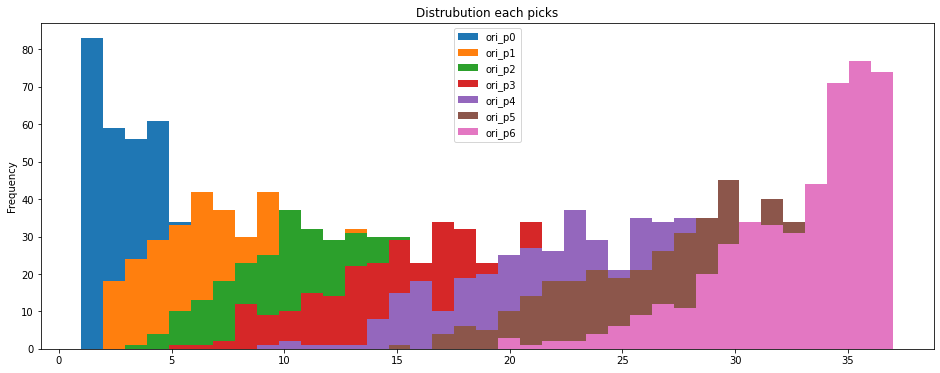

In [17]:
sel_df.plot(kind='hist', bins=37, title='Distrubution each picks')

<AxesSubplot:title={'center':'Distrubution each picks'}, ylabel='Frequency'>

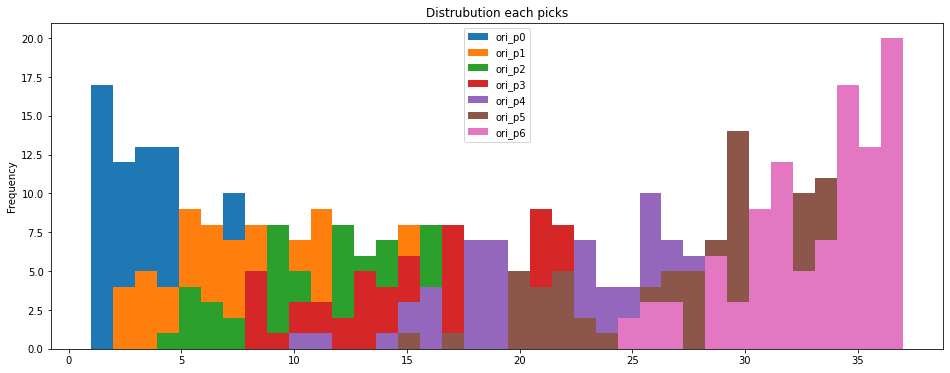

In [18]:
sel_df.iloc[-100:].plot(kind='hist', bins=37, title='Distrubution each picks')

<AxesSubplot:title={'center':'Distrubution all'}, ylabel='Frequency'>

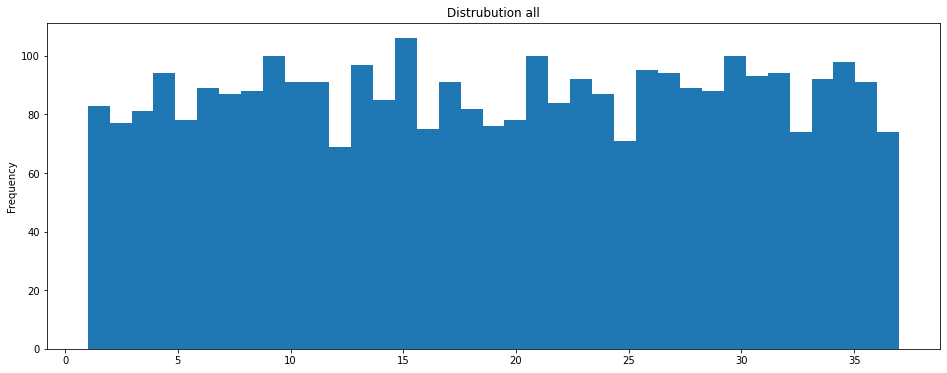

In [19]:
sel_df.stack().reset_index(drop=True).plot(kind='hist', bins=37, title='Distrubution all')

<AxesSubplot:title={'center':'Distrubution all'}, ylabel='Frequency'>

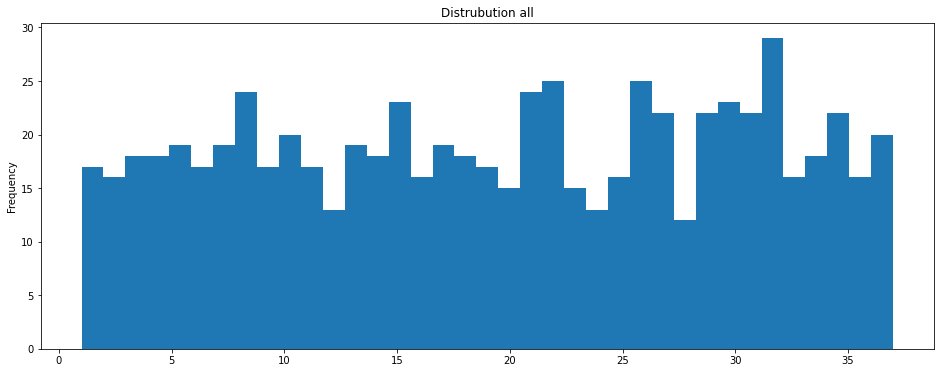

In [20]:
sel_df.iloc[-100:,].stack().reset_index(drop=True).plot(kind='hist', bins=37, title='Distrubution all')

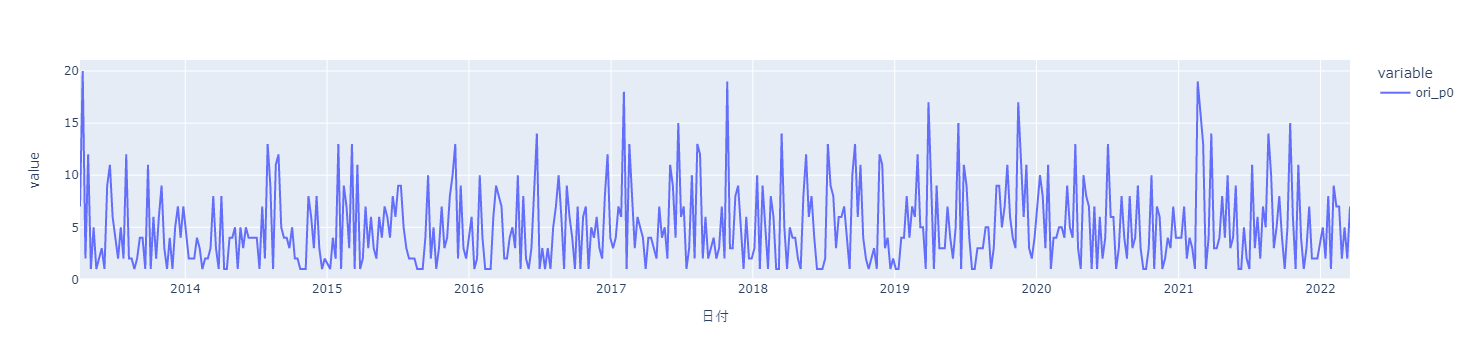

In [22]:
px.line(sel_df['ori_p0'])

### Decompose

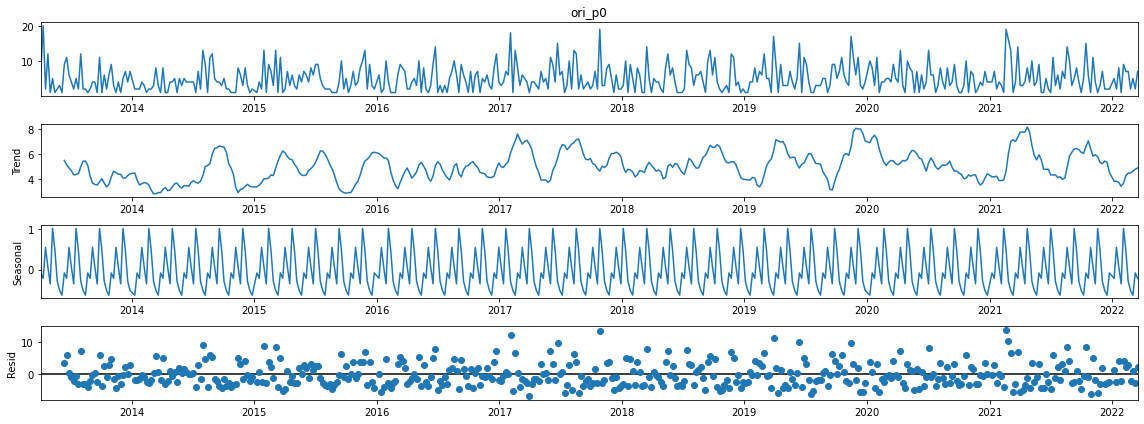

In [23]:
sd_p0 = sm.tsa.seasonal_decompose(sel_df['ori_p0'], period=10, two_sided=False)
fig = sd_p0.plot()

## Prepration

### scale

In [24]:
sc = MinMaxScaler()
sc_df = sel_df.copy()
sc_df[:] = sc.fit_transform(sel_df)
sc_df.tail(1)

,ori_p0,ori_p1,ori_p2,ori_p3,ori_p4,ori_p5,ori_p6
日付,,,,,,,
2022-03-18,0.315789,0.391304,0.75,0.758621,0.769231,0.904762,0.882353


### fe

In [31]:
fe_df = sc_df.copy()
# add one week
index_list = pd.date_range(start=fe_df.index[-1]+relativedelta(weeks=1), end=fe_df.index[-1]+relativedelta(weeks=1))
fe_df = pd.concat([fe_df, pd.DataFrame(index=index_list)])
# shift numbers
weeks = 12
for w in range(1, weeks+1):
    temp_df = fe_df.filter(regex='ori').shift(w).add_suffix(f'_{w}w_ago')
    temp_df.columns = temp_df.columns.str[4:]
    fe_df = pd.concat([fe_df, temp_df], axis=1)
fe_df = fe_df.drop(fe_df.index[:weeks])
print(fe_df.shape)
display( fe_df.head(1) )
display( fe_df.tail() )

(451, 91)


,ori_p0,ori_p1,ori_p2,ori_p3,ori_p4,ori_p5,ori_p6,p0_1w_ago,p1_1w_ago,p2_1w_ago,p3_1w_ago,p4_1w_ago,p5_1w_ago,p6_1w_ago,p0_2w_ago,p1_2w_ago,p2_2w_ago,p3_2w_ago,p4_2w_ago,p5_2w_ago,p6_2w_ago,p0_3w_ago,p1_3w_ago,p2_3w_ago,p3_3w_ago,p4_3w_ago,p5_3w_ago,p6_3w_ago,p0_4w_ago,p1_4w_ago,p2_4w_ago,p3_4w_ago,p4_4w_ago,p5_4w_ago,p6_4w_ago,p0_5w_ago,p1_5w_ago,p2_5w_ago,p3_5w_ago,p4_5w_ago,p5_5w_ago,p6_5w_ago,p0_6w_ago,p1_6w_ago,p2_6w_ago,p3_6w_ago,p4_6w_ago,p5_6w_ago,p6_6w_ago,p0_7w_ago,p1_7w_ago,p2_7w_ago,p3_7w_ago,p4_7w_ago,p5_7w_ago,p6_7w_ago,p0_8w_ago,p1_8w_ago,p2_8w_ago,p3_8w_ago,p4_8w_ago,p5_8w_ago,p6_8w_ago,p0_9w_ago,p1_9w_ago,p2_9w_ago,p3_9w_ago,p4_9w_ago,p5_9w_ago,p6_9w_ago,p0_10w_ago,p1_10w_ago,p2_10w_ago,p3_10w_ago,p4_10w_ago,p5_10w_ago,p6_10w_ago,p0_11w_ago,p1_11w_ago,p2_11w_ago,p3_11w_ago,p4_11w_ago,p5_11w_ago,p6_11w_ago,p0_12w_ago,p1_12w_ago,p2_12w_ago,p3_12w_ago,p4_12w_ago,p5_12w_ago,p6_12w_ago
2013-06-28,0.263158,0.347826,0.464286,0.551724,0.692308,0.619048,0.882353,0.526316,0.434783,0.392857,0.482759,0.653846,0.571429,0.764706,0.421053,0.565217,0.821429,0.827586,0.884615,0.904762,0.941176,0.0,0.0,0.0,0.034483,0.576923,0.619048,0.588235,0.105263,0.086957,0.428571,0.62069,0.692308,0.714286,0.941176,0.052632,0.826087,0.892857,0.827586,0.807692,0.809524,0.941176,0.0,0.043478,0.071429,0.068966,0.692308,0.666667,0.764706,0.210526,0.565217,0.571429,0.62069,0.807692,0.904762,0.882353,0.0,0.043478,0.035714,0.0,0.269231,0.285714,0.470588,0.578947,0.478261,0.678571,0.62069,0.576923,0.619048,0.529412,0.052632,0.217391,0.178571,0.206897,0.192308,0.380952,0.647059,1.0,0.956522,0.928571,0.896552,0.923077,0.904762,0.882353,0.315789,0.347826,0.321429,0.413793,0.538462,0.619048,0.823529


,ori_p0,ori_p1,ori_p2,ori_p3,ori_p4,ori_p5,ori_p6,p0_1w_ago,p1_1w_ago,p2_1w_ago,p3_1w_ago,p4_1w_ago,p5_1w_ago,p6_1w_ago,p0_2w_ago,p1_2w_ago,p2_2w_ago,p3_2w_ago,p4_2w_ago,p5_2w_ago,p6_2w_ago,p0_3w_ago,p1_3w_ago,p2_3w_ago,p3_3w_ago,p4_3w_ago,p5_3w_ago,p6_3w_ago,p0_4w_ago,p1_4w_ago,p2_4w_ago,p3_4w_ago,p4_4w_ago,p5_4w_ago,p6_4w_ago,p0_5w_ago,p1_5w_ago,p2_5w_ago,p3_5w_ago,p4_5w_ago,p5_5w_ago,p6_5w_ago,p0_6w_ago,p1_6w_ago,p2_6w_ago,p3_6w_ago,p4_6w_ago,p5_6w_ago,p6_6w_ago,p0_7w_ago,p1_7w_ago,p2_7w_ago,p3_7w_ago,p4_7w_ago,p5_7w_ago,p6_7w_ago,p0_8w_ago,p1_8w_ago,p2_8w_ago,p3_8w_ago,p4_8w_ago,p5_8w_ago,p6_8w_ago,p0_9w_ago,p1_9w_ago,p2_9w_ago,p3_9w_ago,p4_9w_ago,p5_9w_ago,p6_9w_ago,p0_10w_ago,p1_10w_ago,p2_10w_ago,p3_10w_ago,p4_10w_ago,p5_10w_ago,p6_10w_ago,p0_11w_ago,p1_11w_ago,p2_11w_ago,p3_11w_ago,p4_11w_ago,p5_11w_ago,p6_11w_ago,p0_12w_ago,p1_12w_ago,p2_12w_ago,p3_12w_ago,p4_12w_ago,p5_12w_ago,p6_12w_ago
2022-02-25,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235,0.052632,0.826087,0.821429,0.758621,0.884615,0.857143,0.823529,0.315789,0.826087,0.750000,0.827586,0.884615,1.000000,1.000000,0.105263,0.130435,0.178571,0.275862,0.653846,0.714286,1.000000
2022-03-04,0.210526,0.173913,0.214286,0.620690,0.692308,0.619048,0.588235,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235,0.052632,0.826087,0.821429,0.758621,0.884615,0.857143,0.823529,0.315789,0.826087,0.750000,0.827586,0.884615,1.000000,1.000000
2022-03-11,0.052632,0.478261,0.571429,0.586207,0.884615,0.952381,1.000000,0.210526,0.173913,0.214286,0.620690,0.692308,0.619048,0.588235,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235,0.052632,0.826087,0.821429,0.758621,0.884615,0.857143,0.823529
2022-03-18,0.315789,0.391304,0.750000,0.758621,0.769231,0.904762,0.882353,0.052632,0.478261,0.571429,0.586207,0.884615,0.952381,1.000000,0.210526,0.173913,0.214286,0.620690,0.692308,0.619048,0.588235,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.2

### split

In [67]:
X = fe_df.filter(regex='ago')
y = fe_df.loc[:, [f'ori_p{p}' for p in range(picks)]]
print(X.shape, y.shape)
display(X.tail())
display(y.tail())

(451, 84) (451, 7)


,p0_1w_ago,p1_1w_ago,p2_1w_ago,p3_1w_ago,p4_1w_ago,p5_1w_ago,p6_1w_ago,p0_2w_ago,p1_2w_ago,p2_2w_ago,p3_2w_ago,p4_2w_ago,p5_2w_ago,p6_2w_ago,p0_3w_ago,p1_3w_ago,p2_3w_ago,p3_3w_ago,p4_3w_ago,p5_3w_ago,p6_3w_ago,p0_4w_ago,p1_4w_ago,p2_4w_ago,p3_4w_ago,p4_4w_ago,p5_4w_ago,p6_4w_ago,p0_5w_ago,p1_5w_ago,p2_5w_ago,p3_5w_ago,p4_5w_ago,p5_5w_ago,p6_5w_ago,p0_6w_ago,p1_6w_ago,p2_6w_ago,p3_6w_ago,p4_6w_ago,p5_6w_ago,p6_6w_ago,p0_7w_ago,p1_7w_ago,p2_7w_ago,p3_7w_ago,p4_7w_ago,p5_7w_ago,p6_7w_ago,p0_8w_ago,p1_8w_ago,p2_8w_ago,p3_8w_ago,p4_8w_ago,p5_8w_ago,p6_8w_ago,p0_9w_ago,p1_9w_ago,p2_9w_ago,p3_9w_ago,p4_9w_ago,p5_9w_ago,p6_9w_ago,p0_10w_ago,p1_10w_ago,p2_10w_ago,p3_10w_ago,p4_10w_ago,p5_10w_ago,p6_10w_ago,p0_11w_ago,p1_11w_ago,p2_11w_ago,p3_11w_ago,p4_11w_ago,p5_11w_ago,p6_11w_ago,p0_12w_ago,p1_12w_ago,p2_12w_ago,p3_12w_ago,p4_12w_ago,p5_12w_ago,p6_12w_ago
2022-02-25,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235,0.052632,0.826087,0.821429,0.758621,0.884615,0.857143,0.823529,0.315789,0.826087,0.750000,0.827586,0.884615,1.000000,1.000000,0.105263,0.130435,0.178571,0.275862,0.653846,0.714286,1.000000
2022-03-04,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235,0.052632,0.826087,0.821429,0.758621,0.884615,0.857143,0.823529,0.315789,0.826087,0.750000,0.827586,0.884615,1.000000,1.000000
2022-03-11,0.210526,0.173913,0.214286,0.620690,0.692308,0.619048,0.588235,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235,0.052632,0.826087,0.821429,0.758621,0.884615,0.857143,0.823529
2022-03-18,0.052632,0.478261,0.571429,0.586207,0.884615,0.952381,1.000000,0.210526,0.173913,0.214286,0.620690,0.692308,0.619048,0.588235,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412,0.315789,0.391304,0.321429,0.310345,0.384615,0.285714,0.764706,0.315789,0.521739,0.571429,0.758621,0.846154,0.952381,0.941176,0.421053,0.565217,0.500000,0.448276,0.500000,0.476190,0.647059,0.000000,0.130435,0.178571,0.344828,0.346154,0.523810,0.941176,0.368421,0.652174,0.642857,0.724138,0.692308,0.666667,0.647059,0.052632,0.260870,0.250000,0.551724,0.576923,0.523810,0.882353,0.210526,0.652174,0.607143,0.551724,0.846154,0.904762,0.882353,0.052632,0.565217,0.678571,0.689655,0.730769,0.857143,1.000000,0.052632,0.217391,0.321429,0.344828,0.461538,0.380952,0.588235
2022-03-25,0.315789,0.391304,0.750000,0.758621,0.769231,0.904762,0.882

,ori_p0,ori_p1,ori_p2,ori_p3,ori_p4,ori_p5,ori_p6
2022-02-25,0.052632,0.086957,0.142857,0.103448,0.038462,0.238095,0.529412
2022-03-04,0.210526,0.173913,0.214286,0.620690,0.692308,0.619048,0.588235
2022-03-11,0.052632,0.478261,0.571429,0.586207,0.884615,0.952381,1.000000
2022-03-18,0.315789,0.391304,0.750000,0.758621,0.769231,0.904762,0.882353
2022-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## LSML model

### custom es

In [37]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_loss = np.Inf
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # if loss < 0.001:
        if np.less(val_loss, self.best_val_loss):
            self.best_loss = loss
            self.best_val_loss = val_loss
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.", epoch)
                self.model.set_weights(self.best_weights)

### train

In [68]:
layers = 1
units = 128
dropout = 0.01
batch_size = 32
epochs = 10000
patience = 800

def trainLSTM(X_train, y_train):
    # seed
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # model
    model = Sequential()
    for layer in range(layers+1):
        return_sequences = False if layer == layers else True
        model.add( LSTM(units=units, dropout=dropout, return_sequences=return_sequences, input_shape=(X_train.shape[1], 1)) )

    model.add( Dense(units=picks) )
    model.compile(loss='mse', optimizer='adam')
    
    # fit
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        batch_size=batch_size, epochs=epochs, verbose=0,
        # callbacks=[CustomEarlyStopping(patience=patience)]
    )
    
    return model, history

### run

In [69]:
X_train = X.iloc[:-1,]
y_train = y.iloc[:-1,]
print(X_train.shape, y_train.shape)

%time model, history = trainLSTM(X_train, y_train)

model.summary()

(450, 84) (450, 7)
CPU times: user 38min 4s, sys: 16min 20s, total: 54min 25s
Wall time: 40min 23s
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 84, 128)           66560     
                                                                 
 lstm_13 (LSTM)              (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 7)                 903       
                                                                 
Total params: 199,047
Trainable params: 199,047
Non-trainable params: 0
_________________________________________________________________


### history

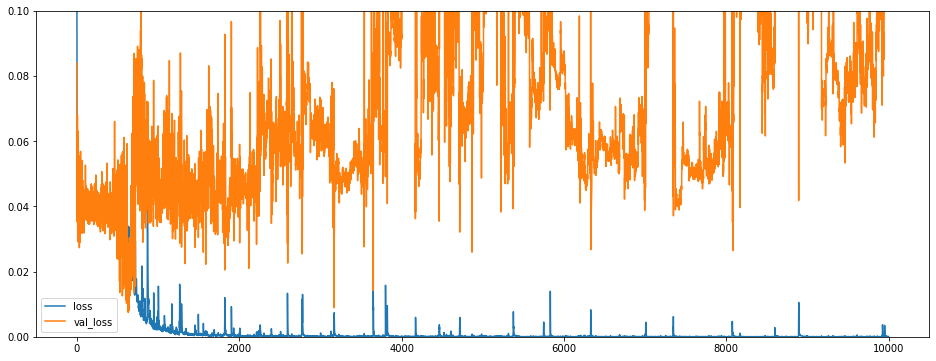

In [70]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0, 0.1)
plt.legend()

### RMSE

In [71]:
X_train = X.iloc[:-1,].copy()
y_train = y.iloc[:-1,].copy()
X_forecast = X.iloc[-1:,].copy()
y_forecast = y.iloc[-1:,].copy()
print(X_train.shape, y_train.shape, X_forecast.shape, y_forecast.shape)

y_train_pred = model.predict(X_train).round()
y_train_pred = sc.inverse_transform(y_train_pred)
y_train_pred = pd.DataFrame(y_train_pred, index=y_train.index)
y_train[:] = sc.inverse_transform(y_train)

rmse = np.sqrt( mean_squared_error(y_train, y_train_pred) )
print('RMSE: {:.5}'.format(rmse))

(450, 84) (450, 7) (1, 84) (1, 7)
RMSE: 7.5856


### accuracy

In [101]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from sklearn.metrics import accuracy_score, classification_report
for i in range(picks):
    print(f'========== {i} ==========')
    print( classification_report(y_train.iloc[:, i].round(0), y_train_pred.iloc[:, i].round(0)) )

========== 0 ==========
              precision    recall  f1-score   support

         1.0       0.20      1.00      0.33        80
         2.0       0.00      0.00      0.00        57
         3.0       0.00      0.00      0.00        55
         4.0       0.00      0.00      0.00        61
         5.0       0.00      0.00      0.00        33
         6.0       0.00      0.00      0.00        33
         7.0       0.00      0.00      0.00        29
         8.0       0.00      0.00      0.00        23
         9.0       0.00      0.00      0.00        22
        10.0       0.00      0.00      0.00        13
        11.0       0.00      0.00      0.00        13
        12.0       0.00      0.00      0.00         7
        13.0       0.00      0.00      0.00        11
        14.0       0.00      0.00      0.00         4
        15.0       0.00      0.00      0.00         3
        16.0       0.00      0.00      0.00         1
        17.0       0.00      0.00      0.00         2
   

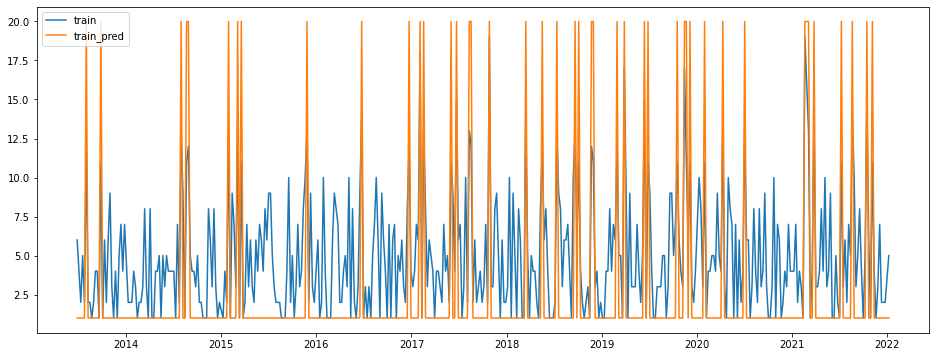

In [65]:
plt.plot(y_train.iloc[:-10, 0], label='train')
plt.plot(y_train_pred.iloc[:-10, 0], label='train_pred')
plt.legend()

### prediction

In [66]:
y_pred = model.predict(X_forecast).round()
y_forecast[:] = sc.inverse_transform(y_pred)
y_forecast

,ori_p0,ori_p1,ori_p2,ori_p3,ori_p4,ori_p5,ori_p6
2022-03-25,1.0,2.0,3.0,5.0,35.0,36.0,37.0


In [47]:
fig = px.line(pd.concat([y_pred, y_train, y_forecast], axis=1))
fig.update_layout({
    'xaxis': {
        'dtick': 'M1'
    }
})
fig.show()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [25]:
%%time

model_list = []
history_list = []

for p in range(picks):
    print('p:', p)
    X_train = sc_df
    y_train = sc_df[f'p{p}']
    model, history = trainLSTM(X_train, y_train)
    
    model_list.append(model)
    history_list.append(history)

p: 0
Restoring model weights from the end of the best epoch. 378
p: 1
p: 2
p: 3
Restoring model weights from the end of the best epoch. 835
p: 4
p: 5
p: 6
p: 7


KeyError: 'p7'

p: 0
p: 1
p: 2
p: 3
p: 4
p: 5
p: 6


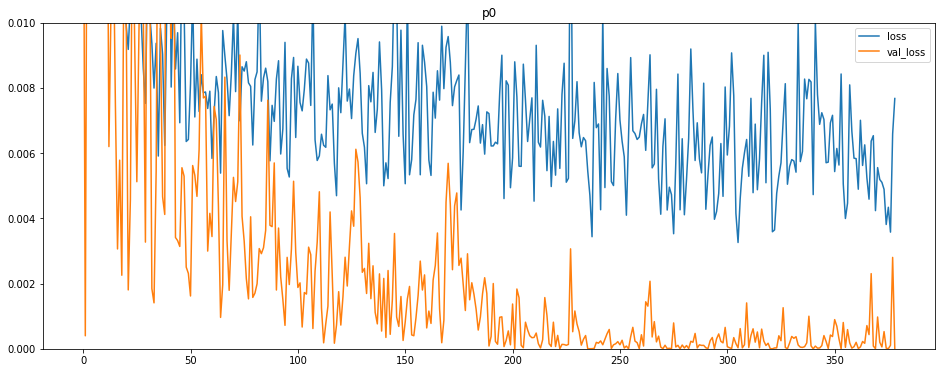

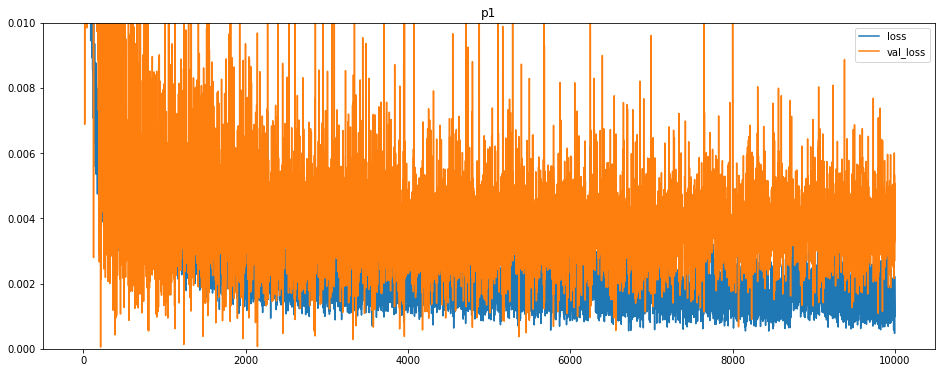

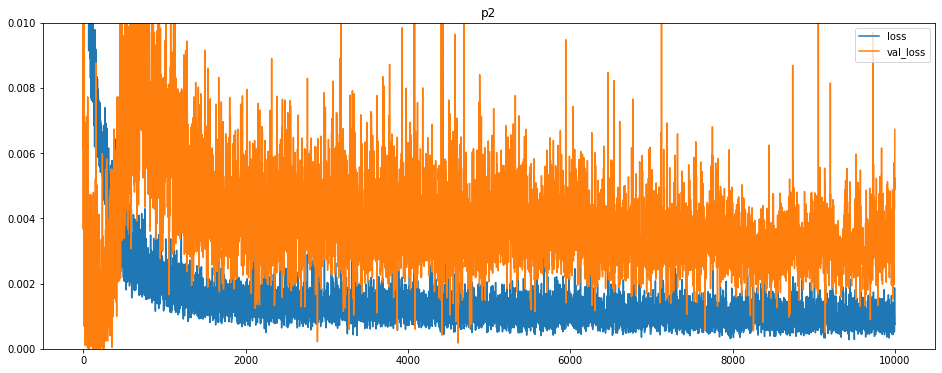

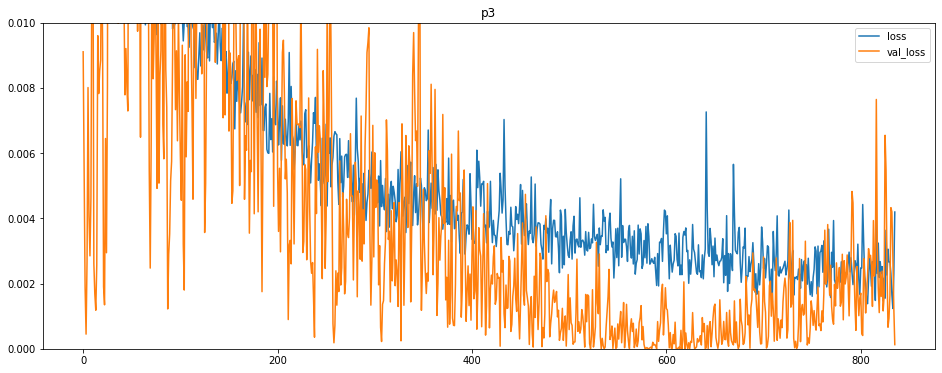

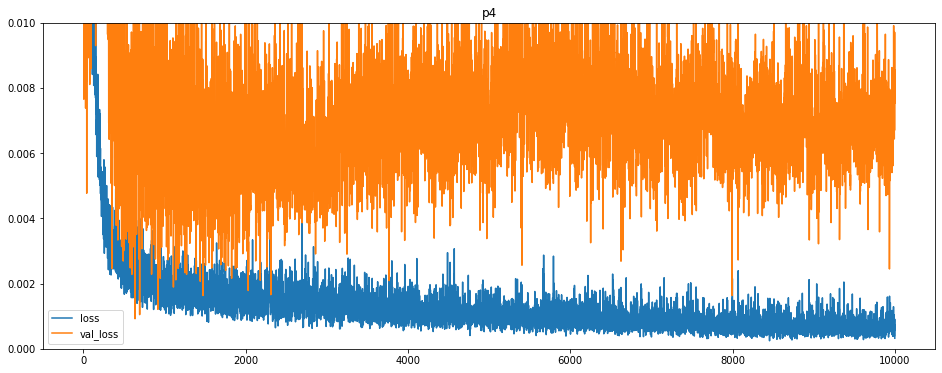

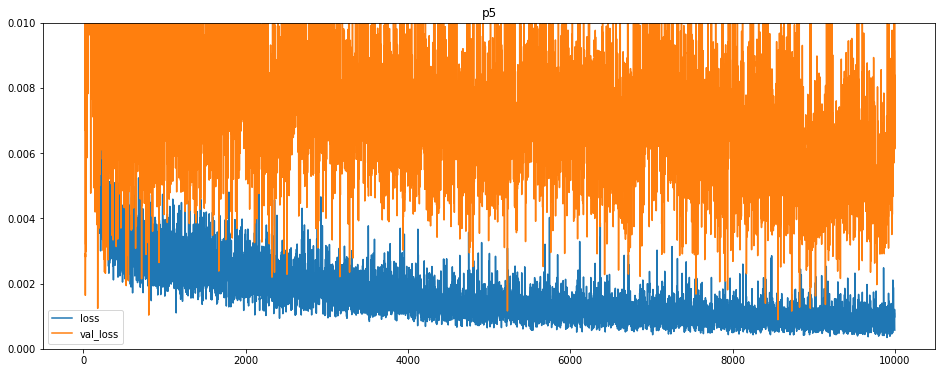

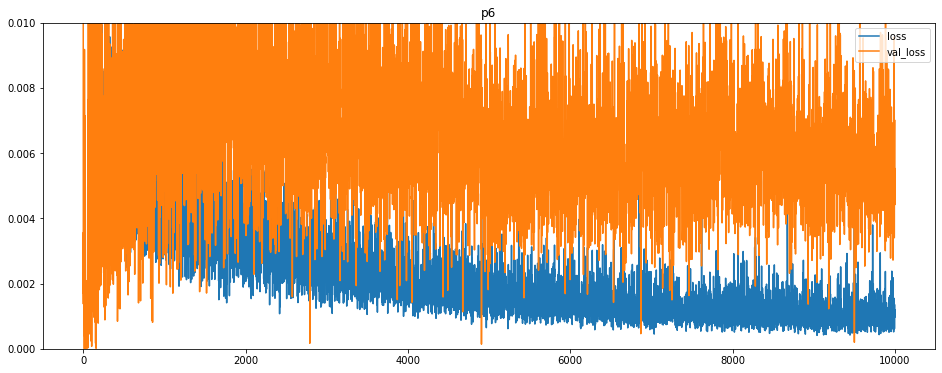

In [30]:
for p in range(picks):
    print('p:', p)
    
    plt.figure()
    plt.plot(history_list[p].history['loss'], label='loss')
    plt.plot(history_list[p].history['val_loss'], label='val_loss')
    plt.ylim(0, 0.01)
    plt.title(f'p{p}')
    plt.legend()

### dump

In [31]:
import joblib

for p in range(picks):
    print('p:', p)
    joblib.dump(model_list[p], f'p{p}.joblib')

p: 0


2022-01-11 12:38:28.987321: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://7c503cd7-5351-4047-a166-ddac0c53d674/assets


INFO:tensorflow:Assets written to: ram://7c503cd7-5351-4047-a166-ddac0c53d674/assets


p: 1


INFO:tensorflow:Assets written to: ram://bc8a0df5-88b2-4eb6-a228-22d9174a6cc2/assets


INFO:tensorflow:Assets written to: ram://bc8a0df5-88b2-4eb6-a228-22d9174a6cc2/assets


p: 2


INFO:tensorflow:Assets written to: ram://5246c36a-c894-4df5-b4cf-fab2a8eb5657/assets


INFO:tensorflow:Assets written to: ram://5246c36a-c894-4df5-b4cf-fab2a8eb5657/assets


p: 3


INFO:tensorflow:Assets written to: ram://937b65d7-7566-49f6-8aee-5d8e906f3986/assets


INFO:tensorflow:Assets written to: ram://937b65d7-7566-49f6-8aee-5d8e906f3986/assets


p: 4


INFO:tensorflow:Assets written to: ram://bd45421a-677c-4ea5-8fcd-0fa5a5062aec/assets


INFO:tensorflow:Assets written to: ram://bd45421a-677c-4ea5-8fcd-0fa5a5062aec/assets


p: 5


INFO:tensorflow:Assets written to: ram://329a41bf-0874-4b84-982e-95ab72d2199e/assets


INFO:tensorflow:Assets written to: ram://329a41bf-0874-4b84-982e-95ab72d2199e/assets


p: 6


INFO:tensorflow:Assets written to: ram://faeb9770-96e3-4edc-b46b-a5bdcf534460/assets


INFO:tensorflow:Assets written to: ram://faeb9770-96e3-4edc-b46b-a5bdcf534460/assets


### load

In [18]:
import joblib

model_list = []
for p in range(picks):
    print('p:', p)
    model_list.append( joblib.load(f'p{p}.joblib') )

p: 0


2022-01-11 22:02:40.208547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-11 22:02:40.239622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-11 22:02:40.240031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-01-11 22:02:40.241093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

p: 1
p: 2
p: 3
p: 4
p: 5
p: 6


## 2. Data preparatino
### 2.1 One-hot

In [17]:
# ont-hot
def oneHot(list_2d):
    data_list = []
    for row in list_2d:
        bins = [ 0 for i in range(conf.max_n) ]
        for e in row:
            bins[int(e)-1] = 1
        data_list.append( bins )
    return np.array(data_list)

columns = [ str(i) for i in range(conf.max_n) ]
data_one_hot = pd.DataFrame(oneHot(data_selected.values), columns=columns)
data_one_hot

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,0
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,1,0,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
430,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
431,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


### 2.2 Create dataset

In [96]:
X = data_one_hot.drop(data_one_hot.tail(1).index)
y = data_one_hot.drop(data_one_hot.head(1).index)
print('X shape: ', X.shape, ', y shape: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print('X_train shape: ', X_train.shape, ', y_train shape: ',y_train.shape)
print('X_test shape: ', X_test.shape, ', y_test shape: ',y_test.shape)

X shape:  (433, 37) , y shape:  (433, 37)
X_train shape:  (346, 37) , y_train shape:  (346, 37)
X_test shape:  (87, 37) , y_test shape:  (87, 37)


## 3. Models

### 3.1 Define Models

In [92]:
#from sklearn.multioutput import MultiOutputClassifier

#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neural_network import MLPClassifier
#from sklearn.svm import SVC


from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR

models = {
    'RandomForestRegressor': MultiOutputRegressor(RandomForestRegressor()),
    'GaussianProcessRegressor': MultiOutputRegressor(GaussianProcessRegressor()),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'KNeighborsRegressor': MultiOutputRegressor(KNeighborsRegressor()),
    'MLPRegressor': MultiOutputRegressor(MLPRegressor(max_iter=500)),
    'LinearSVR': MultiOutputRegressor(LinearSVR()),
}

In [158]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    print('classifier: ', key, 'score: ', classifier.score(X_train, y_train) )

classifier:  GaussianNB score:  0.0
classifier:  LogisticRegression score:  0.0
classifier:  KNeighborsClassifier score:  0.0
classifier:  MLPClassifier score:  1.0
classifier:  RandomForestClassifier score:  1.0
classifier:  SVC score:  0.0


### 3.2 Training

In [93]:
from sklearn.model_selection import cross_val_score

for key, model in models.items():
    model.fit(X_train, y_train)
    print('classifier: ', key.ljust(25), 
         ', cv score: ', cross_val_score(model, X_train, y_train) )

classifier:  RandomForestRegressor     , cv score:  [-0.13248117 -0.14641472 -0.15351631 -0.1579062  -0.17340559]
classifier:  GaussianProcessRegressor  , cv score:  [-0.72688673 -0.76794633 -0.80273348 -0.77061025 -0.77796575]
classifier:  LinearRegression          , cv score:  [-0.18776493 -0.22848476 -0.21490366 -0.19771487 -0.23661452]
classifier:  KNeighborsRegressor       , cv score:  [-0.21679217 -0.21024251 -0.23032203 -0.23781712 -0.24198929]
classifier:  MLPRegressor              , cv score:  [-0.40962144 -0.52389561 -0.46775124 -0.46386503 -0.53921895]
classifier:  LinearSVR                 , cv score:  [-0.23679972 -0.23688441 -0.23952407 -0.23788777 -0.23740278]


### 3.3 Evaluation

In [97]:
from sklearn.metrics import accuracy_score, classification_report

for key, model in models.items():
    #if key == 'MultiOutputRegressor_GradientBoostingRegressor':
    #    continue
    y_pred_ori = model.predict(X_test)
    # get tok k
    y_pred = y_pred_ori.argsort()[:, -conf.picks:]
    # back to real number
    y_pred += 1
    # one-hot
    y_pred = oneHot(y_pred)
    # Get True counts in all
    y_pred = np.sum( (y_pred == y_test), axis=1)
    # Get wrong counts
    y_pred = (conf.max_n - y_pred)/2
    # Get correct counts
    y_pred = abs(conf.picks - y_pred)
    # Calculate accuracy
    accuracy = y_pred.sum()/(conf.picks * y_pred.count())
    print('-'*50)
    print('classifier: ', key.ljust(25),
          ', accuracy: ', round(accuracy, 4) )
    #print(y_pred_ori)
    #print( classification_report(y_test, y_pred_ori) )
    #print( accuracy_score(y_test, y_pred_ori) )
    #print( multilabel_confusion_matrix(y_test, y_pred) )

--------------------------------------------------
classifier:  RandomForestRegressor     , accuracy:  0.1609
--------------------------------------------------
classifier:  GaussianProcessRegressor  , accuracy:  0.1626
--------------------------------------------------
classifier:  LinearRegression          , accuracy:  0.1856
--------------------------------------------------
classifier:  KNeighborsRegressor       , accuracy:  0.1626
--------------------------------------------------
classifier:  MLPRegressor              , accuracy:  0.1954
--------------------------------------------------
classifier:  LinearSVR                 , accuracy:  0.1856


## 4. Predict next picks

In [102]:
print('last picks: ')
print(data_selected.tail())

n_last = data_one_hot.tail(1).index.tolist()[0]
print('predict #', n_last+1+1, ', picks: ') # becareful! index starts from 0

X_last = np.array([data_one_hot.iloc[-1]])

y_pred_one_hot = np.array([ 0.0 for i in range(conf.max_n) ])
for key, model in models.items():
    y_pred = model.predict(X_last)
    #y_pred_one_hot += y_pred[0] ##
    # get tok k
    y_pred = y_pred.argsort()[:, -conf.picks:]
    # back to real number
    y_pred += 1
    # sort
    y_pred.sort()
    print('classifier: ', key.rjust(25), '-->', y_pred[0])
    # one-hot
    y_pred_one_hot += oneHot(y_pred)[0]

# Get top k
y_final = y_pred_one_hot.argsort()[-conf.picks:]
# back to real number
y_final += 1
# sort
y_final.sort()
print('final picks: ', y_final)

last picks: 
     p0  p1  p2  p3  p4  p5  p6
429   2  12  17  24  28  30  32
430   7  11  12  17  19  20  26
431   5  10  13  24  29  30  35
432  14  17  20  25  32  33  36
433  10  11  12  17  29  34  37
predict # 435 , picks: 
classifier:      RandomForestRegressor --> [ 1  5 12 16 23 34 35]
classifier:   GaussianProcessRegressor --> [ 1  2  4  5 11 12 23]
classifier:           LinearRegression --> [ 2  6 11 17 22 30 35]
classifier:        KNeighborsRegressor --> [ 2  4  6  7 10 19 23]
classifier:               MLPRegressor --> [ 1  2 15 21 22 28 30]
classifier:                  LinearSVR --> [ 6  7 14 17 21 24 26]
final picks:  [ 1  2  4  5  6 23 35]


## TODO
- remove past case